In [1]:
import bpreveal.plotting as bprplots
import h5py
import matplotlib.pyplot as plt
import numpy as np
from bpreveal import utils
from bpreveal import colors as bprcolors

BASE_DIRECTORY="/n/projects/cm2363/bpreveal"
WORKING_DIRECTORY=BASE_DIRECTORY + "/test/acceptance/oskn-4.1.4"
GENOME_FASTA="/n/data1/genomes/indexes/mm10/mm10.fa"
OUTPUT_LENGTH=1000
CONV1_SIZE=7
PROFILE_CONV_SIZE=7
input_length_str = !lengthCalc --output-len {OUTPUT_LENGTH} \
                               --n-dil-layers 9 \
                               --conv1-kernel-size {CONV1_SIZE} \
                               --profile-kernel-size {PROFILE_CONV_SIZE}
INPUT_LENGTH=int(input_length_str[0])
RECEPTIVE_FIELD=INPUT_LENGTH - OUTPUT_LENGTH + 1
windowStart = 180924752-1000
windowEnd = 180925152+1000
windowLen = windowEnd - windowStart
windowChrom = "chr1"

In [2]:
def inflateZeros(ar):
    newAr = np.copy(ar)
    for i in range(1, ar.shape[0] - 1):
        for j in range(1, ar.shape[1] - 1):
            if ar[i,j] == -1:
                foundOff = 0
                for oi in [-1, 0, 1]:
                    for oj in [-1, 0, 1]:
                        if oi != 0 or oj != 0:
                            foundOff = foundOff or ar[i+oi, j+oj] != -1
                if foundOff:
                    newAr[i,j] = 0
    return newAr

def showPisaFile(mode):
    fig = plt.figure(figsize=(5,4), dpi=300)
    #ax2 = fig.add_axes([0, 0, 1, 1])


    lim=0.05
    with h5py.File(WORKING_DIRECTORY + "/shap/pisa_nanog_positive.h5", "r") as fp:
        dats = fp["shap"]
        dats = np.sum(dats, axis=2)
    ticks,labels = bprplots.getCoordinateTicks(windowStart, windowEnd, 11, True)
    if mode == 0:
        ax = fig.add_axes([0.15, 0.15, 0.8, 0.8])
        ax.imshow(dats, vmin=-lim, vmax=lim, cmap='RdBu_r', extent = [-RECEPTIVE_FIELD //2, RECEPTIVE_FIELD //2, windowLen, 0])
        ax.set_yticks(ticks, labels)
        ax.set_xlabel("Distance from output base")
        ax.set_ylabel("Coordinate of output base")
        ax.grid()
    if mode == 1:
        ax = fig.add_axes([0.25, 0.25, 0.7, 0.7])
        shearMat = np.zeros((windowLen, windowLen + RECEPTIVE_FIELD)) - 1
        for row in range(windowLen):
            shearMat[row, row:row+RECEPTIVE_FIELD] = dats[row]
        ax.imshow(inflateZeros(shearMat), vmin=-lim, vmax=lim, cmap='RdBu_r',
                   extent=[-RECEPTIVE_FIELD//2, RECEPTIVE_FIELD//2 + windowLen, windowLen, 0])
        ax.set_yticks(ticks, labels)
        ax.set_xticks(ticks, labels, rotation=30, ha='right')
        ax.set_ylabel("Coordinate of output base")
        ax.set_xlabel("Coordinate of input base")
        ax.grid()
    if mode == 2:
        ax = fig.add_axes([0.25, 0.25, 0.7, 0.7])
        loadedPisa = utils.loadPisa(WORKING_DIRECTORY + "/shap/pisa_nanog_positive.h5")
        loadedPisa[loadedPisa == 0] = -1
        ax.imshow(inflateZeros(loadedPisa), vmin=-lim, vmax=lim, cmap='RdBu_r')
        ax.set_yticks(ticks, labels)
        ax.set_xticks(ticks, labels, rotation=30, ha='right')
        ax.set_ylabel("Coordinate of output base")
        ax.set_xlabel("Coordinate of input base")
        ax.grid()
    if mode == 3:
        ax = fig.add_axes([0.1, 0.1, 0.85, 0.85])
        numLines = 15
        lineDelta = 30
        for i in range(numLines):
            yval = i * lineDelta + windowStart
            o = lineDelta / 6
            #plt.plot([windowStart - RECEPTIVE_FIELD //2 + i * lineDelta, windowStart + i * lineDelta],
            #         [yval, yval], 'k-')
            ax.plot([windowStart + i * lineDelta, windowStart + i * lineDelta + OUTPUT_LENGTH],
                     [yval, yval], 'r-')
            ax.plot([windowStart + i * lineDelta - RECEPTIVE_FIELD // 2, windowStart + i * lineDelta + RECEPTIVE_FIELD//2],
                     [yval-o, yval-o], 'g-')
            ax.plot([windowStart + i * lineDelta - RECEPTIVE_FIELD // 2, windowStart + i * lineDelta + OUTPUT_LENGTH + RECEPTIVE_FIELD // 2],
                     [yval+o, yval+o], 'k-')
            dotpos = windowStart + i * lineDelta
            ax.plot([dotpos, dotpos, dotpos], [yval - o, yval, yval + o], 'b.')
        ax.set_xticks([windowStart - RECEPTIVE_FIELD // 2, windowStart, windowStart + OUTPUT_LENGTH, windowStart + OUTPUT_LENGTH + RECEPTIVE_FIELD // 2])
        ax.set_ylim(windowStart + lineDelta * (numLines + 1), windowStart - lineDelta*2)
        ax.grid()
    return fig


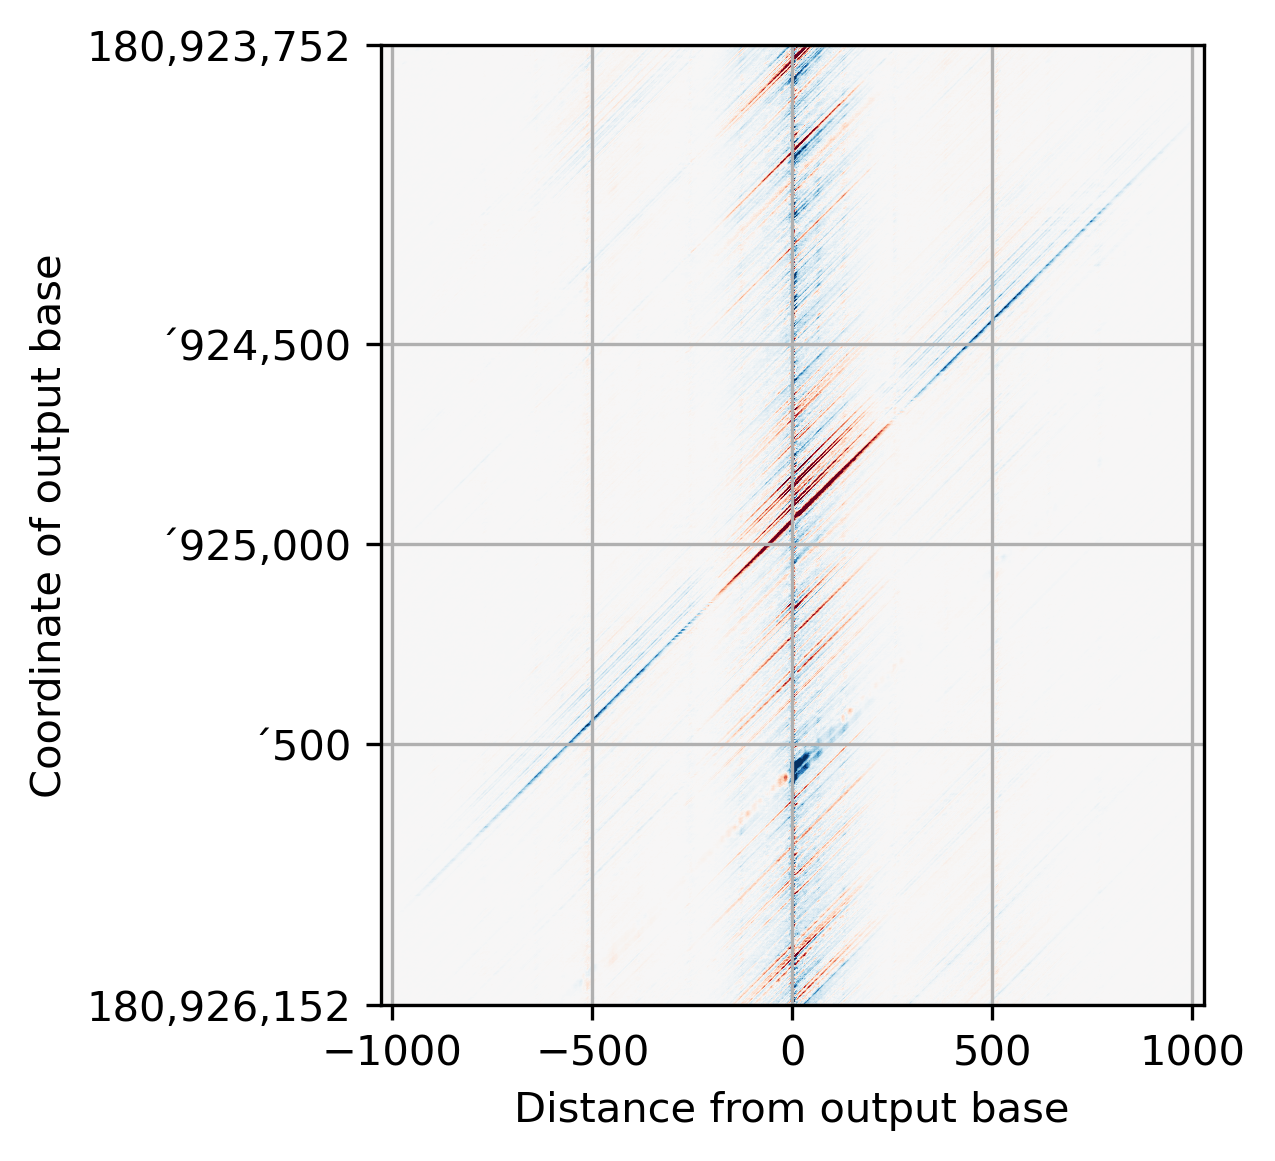

In [3]:
f0 = showPisaFile(0)
f0.savefig("../presentations/pisaRaw.png")

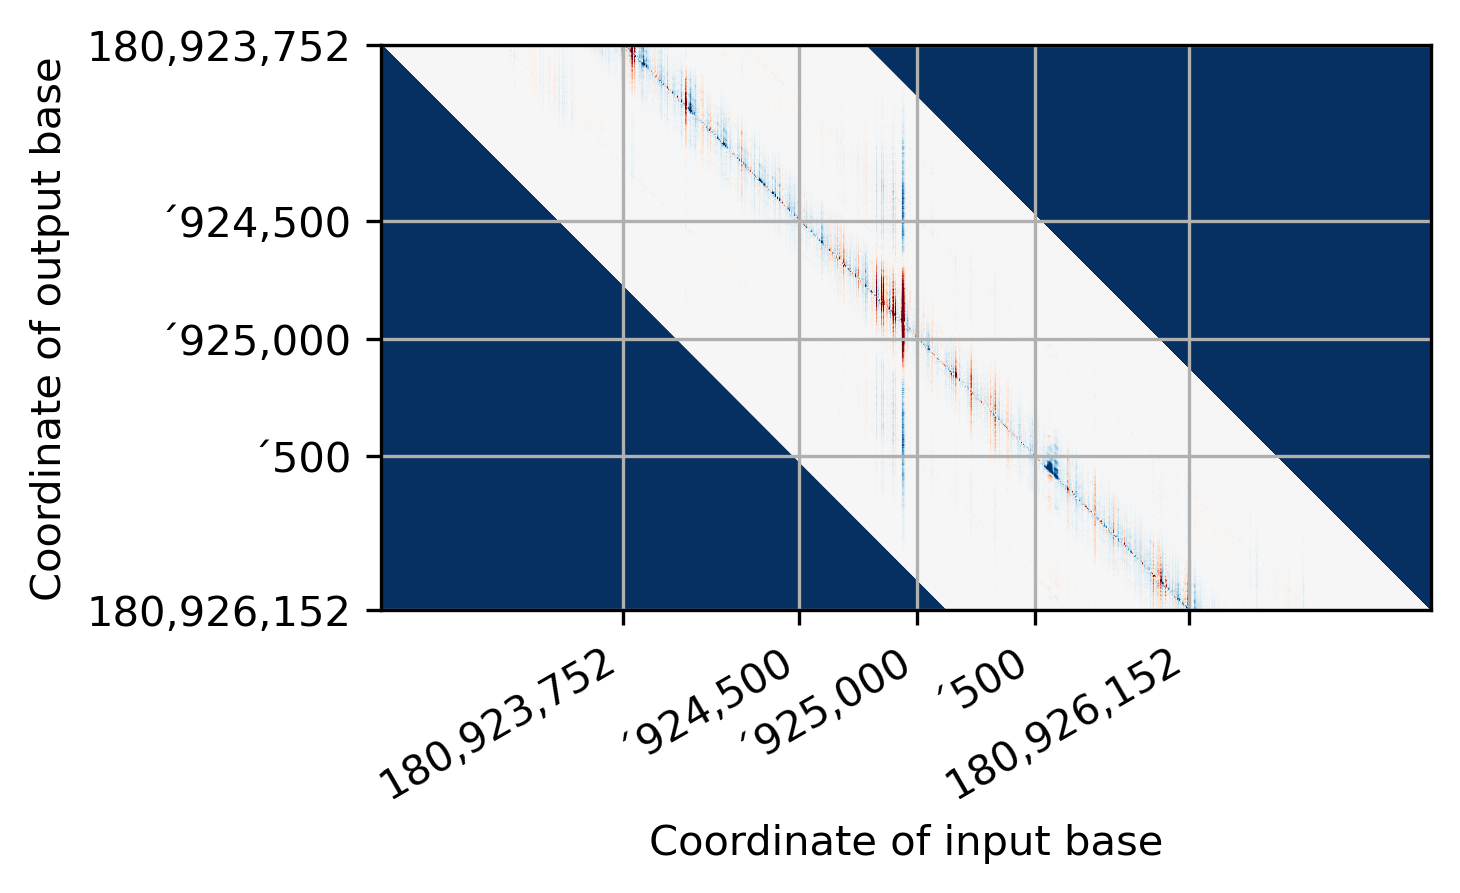

In [4]:
f1 = showPisaFile(1)
f1.savefig("../presentations/pisaShear.png")

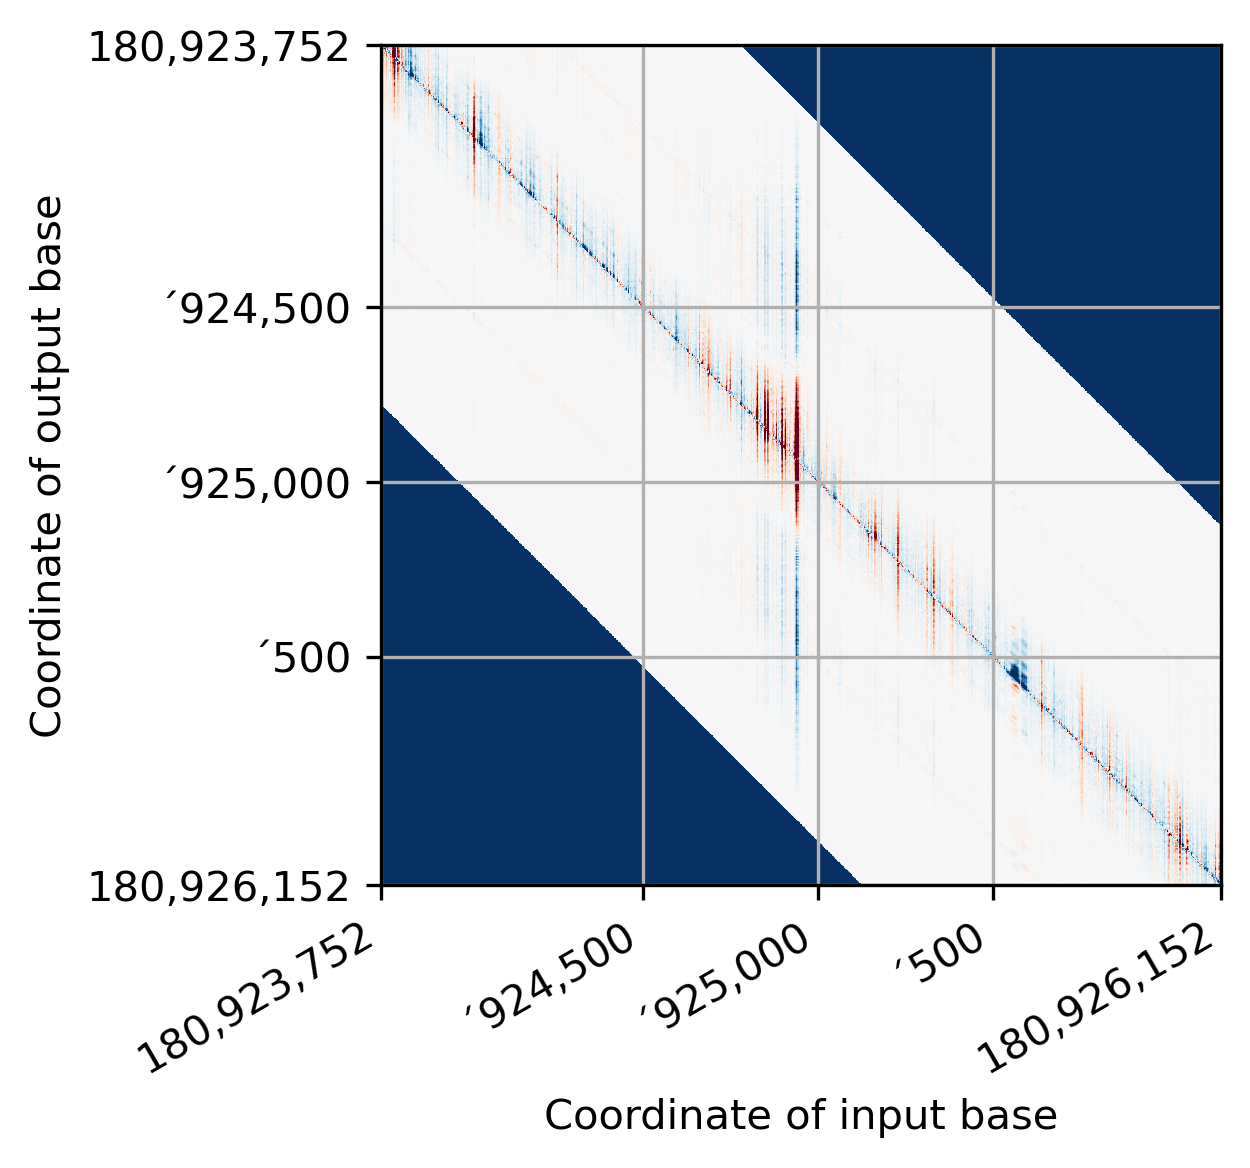

In [5]:
f2 = showPisaFile(2)
f2.savefig("../presentations/pisaLoad.png")

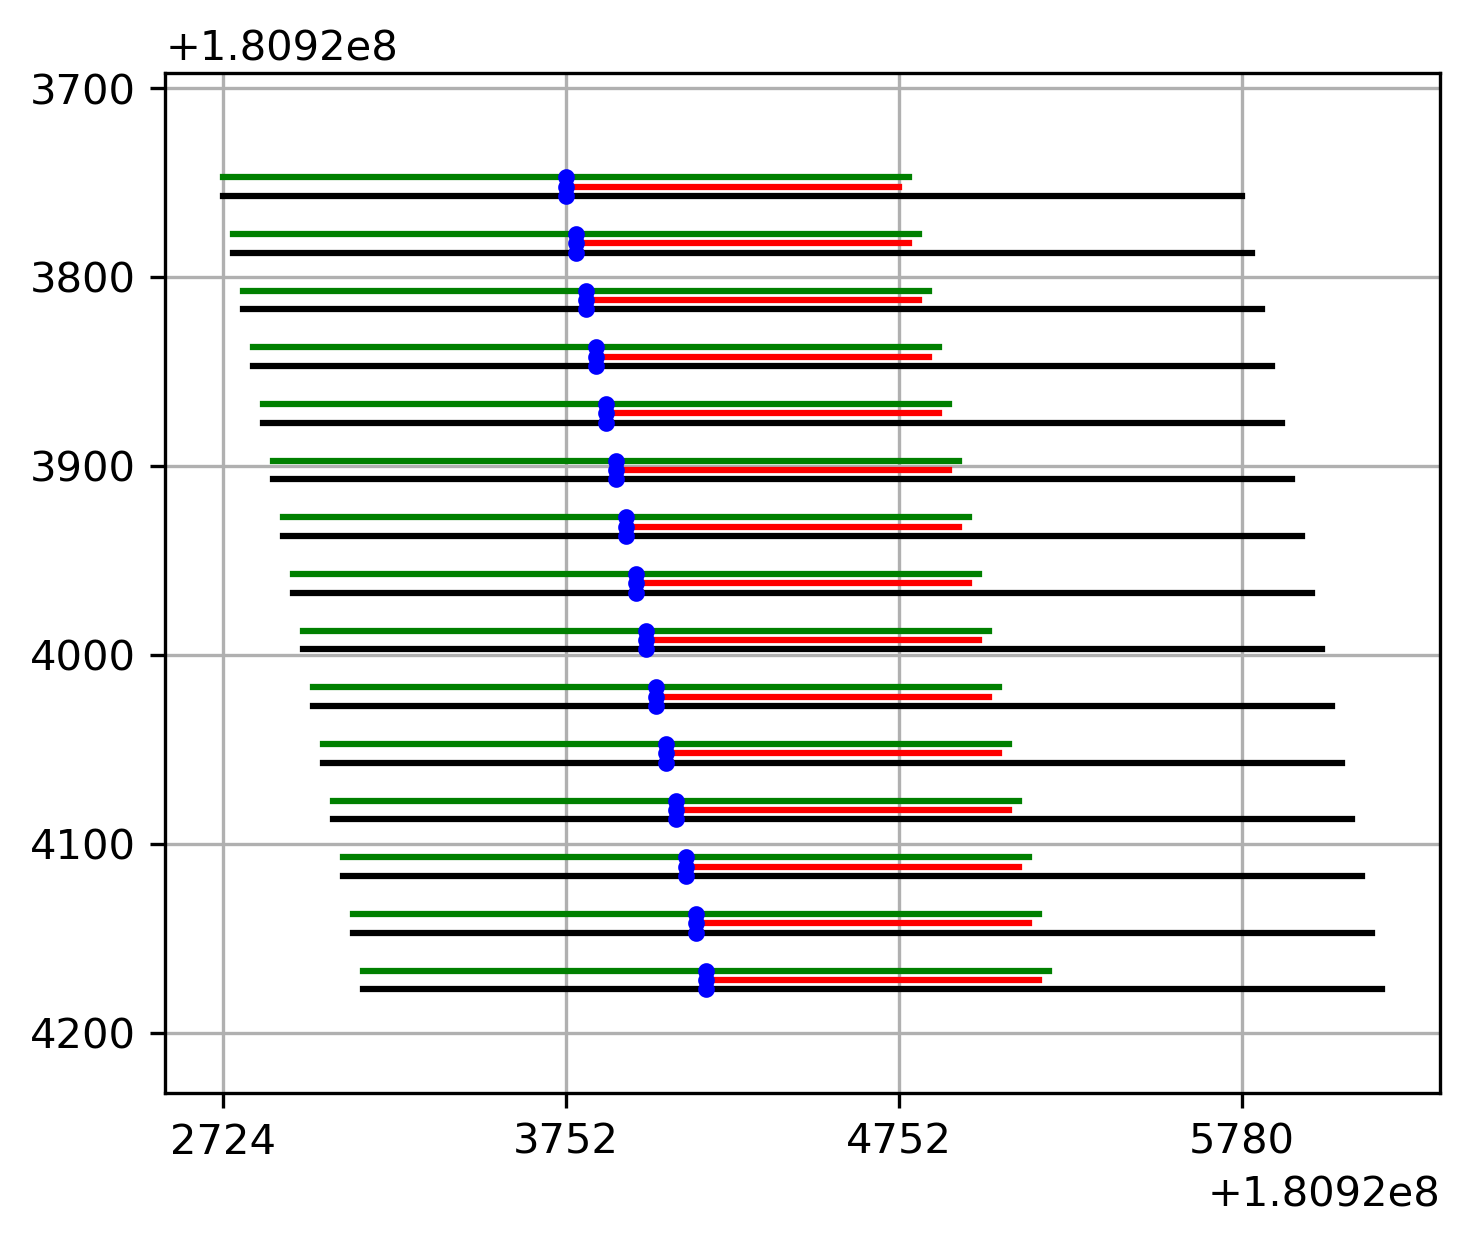

In [6]:
f3 = showPisaFile(3)
f3.savefig("../presentations/pisaDiagram.png")

In [7]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

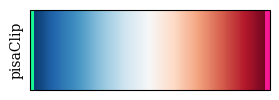

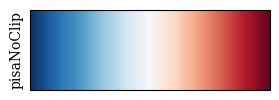

In [8]:
cmap = bprcolors.pisaClip
norm = mcolors.Normalize(vmin=-1, vmax=1)
smap = cm.ScalarMappable(norm=norm, cmap=cmap)
f = plt.figure(figsize=(3,1))
ax = f.add_axes([0.1, 0.1, 0.8, 0.8])
f.colorbar(smap, cax=ax, orientation='horizontal')
ax.set_ylabel("pisaClip", fontfamily="serif")
ax.set_xticks([])
f.savefig("../presentations/pisaClip.png", dpi=300, transparent=True)

f = plt.figure(figsize=(3,1))
#f.add_axes([0,0,1,1])
cmap = bprcolors.pisaNoClip
smap = cm.ScalarMappable(norm=norm, cmap=cmap)
ax = f.add_axes([0.1, 0.1, 0.8, 0.8])
f.colorbar(smap, cax=ax, orientation='horizontal')
ax.set_ylabel("pisaNoClip", fontfamily="serif")
ax.set_xticks([])
f.savefig("../presentations/pisaNoClip.png", dpi=300, transparent=True)

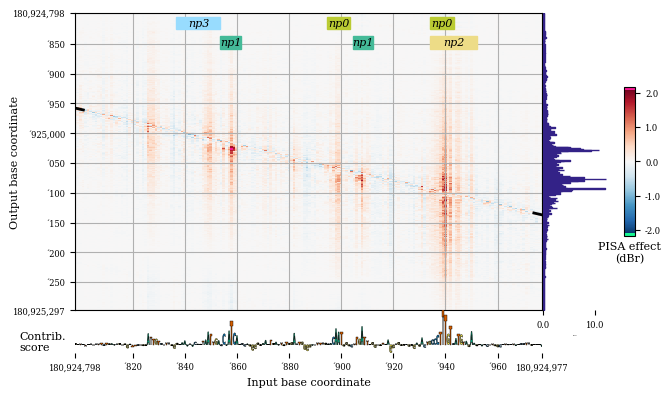

In [9]:
import importlib
importlib.reload(bprplots)
fig = plt.figure(figsize=(7,4))
#fig.add_axes([0,0,1,1])
pisaSection = {
    "h5-name": WORKING_DIRECTORY + "/shap/pisa_nanog_negative.h5"
}

coordinatesSection = {
    "genome-fasta": GENOME_FASTA,
    "midpoint-offset": 1135,
    "input-slice-width": 180,
    "output-slice-width": 500,
    "genome-window-start": windowStart,
    "genome-window-chrom": windowChrom
}

predictionSection = {
    "bigwig-name": WORKING_DIRECTORY + "/pred/nanog_residual_negative.bw"
}

importanceSection = {
    "bigwig-name": WORKING_DIRECTORY + "/shap/nanog_profile.bw",
    "show-sequence": True
}

annotationSection = {
    "bed-name": WORKING_DIRECTORY + "/scan/nanog_profile.bed"
}

figureSectionPlot = {
    "left": 0.12,
    "bottom": 0.13,
    "width": 0.8,
    "height": 0.85,
    "color-span": 0.5,
    "miniature": False
}

plotConfig = {
    "pisa": pisaSection,
    "coordinates": coordinatesSection,
    "importance": importanceSection,
    "predictions": predictionSection,
    "annotations": annotationSection,
    "figure": figureSectionPlot
}


bprplots.plotPisa(plotConfig, fig);
#nc = r["name-colors"]
#annotationSection["name-colors"] = nc
#bprplots.plotPisaGraph(graphConfig, fig);
fig.savefig("../presentations/pisaPlot.png", dpi=300)

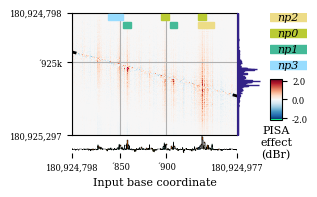

In [10]:
fig = plt.figure(figsize=(3,2))
#fig.add_axes([0,0,1,1])
figsec = figureSectionPlot.copy()
figureSectionMiniaturePlot = {
    "left": 0.21,
    "bottom": 0.2,
    "width": 0.7,
    "height": 0.7,
    "color-span": 0.5,
    "miniature": True
}
plotConfig = {
    "pisa": pisaSection,
    "coordinates": coordinatesSection,
    "importance": importanceSection,
    "predictions": predictionSection,
    "annotations": annotationSection,
    "figure": figureSectionMiniaturePlot
}

r = bprplots.plotPisa(plotConfig, fig);
bprplots.deleteTick(r["axes"]["importance"], "x", -2)
bprplots.deleteTick(r["axes"]["pisa"], "x", -2)
fig.savefig("../presentations/pisaPlotMini.png", dpi=300)

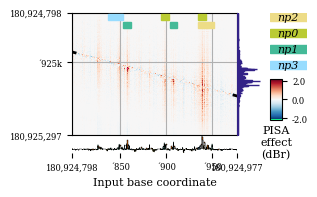

In [11]:
fig = plt.figure(figsize=(3,2))
#fig.add_axes([0,0,1,1])
figsec = figureSectionPlot.copy()
figureSectionMiniaturePlot = {
    "left": 0.21,
    "bottom": 0.2,
    "width": 0.7,
    "height": 0.7,
    "color-span": 0.5,
    "miniature": True
}
plotConfig = {
    "pisa": pisaSection,
    "coordinates": coordinatesSection,
    "importance": importanceSection,
    "predictions": predictionSection,
    "annotations": annotationSection,
    "figure": figureSectionMiniaturePlot
}

r = bprplots.plotPisa(plotConfig, fig);
fig.savefig("../presentations/pisaPlotMiniOverlappingLabels.png", dpi=300)

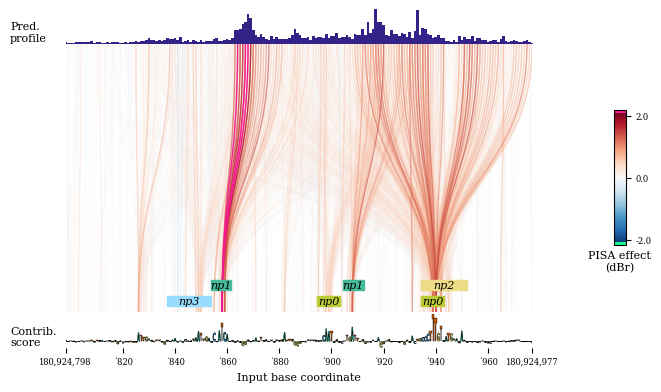

In [12]:
fig = plt.figure(figsize=(7,4))
#fig.add_axes([0,0,1,1])

figureSectionGraph = {
    "left": 0.12,
    "bottom": 0.13,
    "width": 0.8,
    "height": 0.85,
    "color-span": 0.5,
    "annotation-height": 0.2,
    "miniature": False
}

graphConfig = {
    "pisa": pisaSection,
    "coordinates": coordinatesSection,
    "importance": importanceSection,
    "predictions": predictionSection,
    "annotations": annotationSection,
    "figure": figureSectionGraph,
    "min-value": 0.1
}
bprplots.plotPisaGraph(graphConfig, fig);
fig.savefig("../presentations/pisaGraph.png", dpi=300)

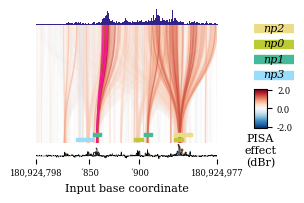

In [13]:
fig = plt.figure(figsize=(3,2))

figureSectionMiniatureGraph = {
    "left": 0.11,
    "bottom": 0.2,
    "width": 0.77,
    "height": 0.75,
    "color-span": 0.5,
    "miniature": True
}
graphConfig = {
    "pisa": pisaSection,
    "coordinates": coordinatesSection,
    "importance": importanceSection,
    "predictions": predictionSection,
    "annotations": annotationSection,
    "figure": figureSectionMiniatureGraph,
    "min-value": 0.1
}

r = bprplots.plotPisaGraph(graphConfig, fig);
bprplots.deleteTick(r["axes"]["importance"], "x", -2)
fig.savefig("../presentations/pisaGraphMini.png", dpi=300)

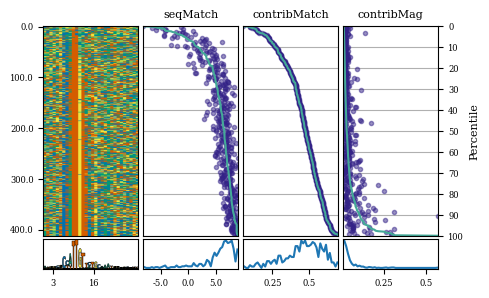

In [14]:
from bpreveal import motifUtils
importlib.reload(bprplots)
bgProbs = [0.291, 0.208, 0.208, 0.291]
pat = motifUtils.Pattern("pos_patterns", "pattern_0", 'sp0')
with h5py.File(WORKING_DIRECTORY + "/modisco/sox2_profile/modisco.h5", "r") as fp:
    pat.loadCwm(fp, 0.3, 3, bgProbs)
    pat.loadSeqlets(fp)
fig = plt.figure(figsize=(5,3))
bprplots.plotModiscoPattern(pat, fig, sortKey = [x.contribMatch for x in pat.seqlets])
fig.savefig("../presentations/modiscoPattern.png", dpi=300)

In [15]:
import math

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle


def plot_colortable(colors, *, ncols=4, sort_colors=True):


    cell_width = 72
    cell_height = 52
    swatch_width = 48
    margin = 12

    # Sort colors by hue, saturation, value and name.
    if sort_colors is True:
        names = sorted(
            colors, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c))))
    else:
        names = list(colors)

    n = len(names)
    nrows = math.ceil(n / ncols)

    width = cell_width * ncols + 2 * margin
    height = cell_height * nrows + 2 * margin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-margin)/height)
    ax.set_xlim(0, cell_width * ncols)
    ax.set_ylim(cell_height * (nrows), -cell_height/2.)
    #ax.yaxis.set_visible(False)
    #ax.xaxis.set_visible(False)
    ax.set_axis_off()

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width / 2.5

        ax.text(text_pos_x, y - 20, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=48, facecolor=colors[name], edgecolor='0.7')
        )


    return fig


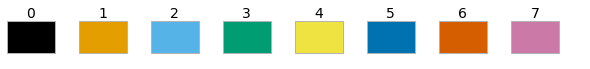

In [16]:
f = plot_colortable(
    {x: bprcolors.wong[x] for x in range(len(bprcolors.wong))},
    sort_colors=False, ncols=8)
f.savefig("../presentations/wong.png", dpi=300, transparent=True)

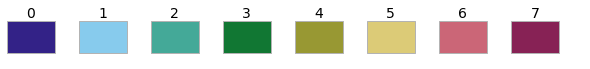

In [17]:
f = plot_colortable(
    {x: bprcolors.tol[x] for x in range(len(bprcolors.wong))},
    sort_colors=False, ncols=8)
f.savefig("../presentations/tol.png", dpi=300, transparent=True)

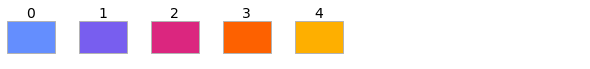

In [18]:
f = plot_colortable(
    {x: bprcolors.ibm[x] for x in range(len(bprcolors.ibm))},
    sort_colors=False, ncols=8);
f.savefig("../presentations/ibm.png", dpi=300, transparent=True)

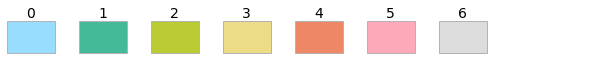

In [19]:
f = plot_colortable(
    {x: bprcolors.tolLight[x] for x in range(len(bprcolors.tolLight))},
    sort_colors=False, ncols=8);
f.savefig("../presentations/tolLight.png", dpi=300, transparent=True)

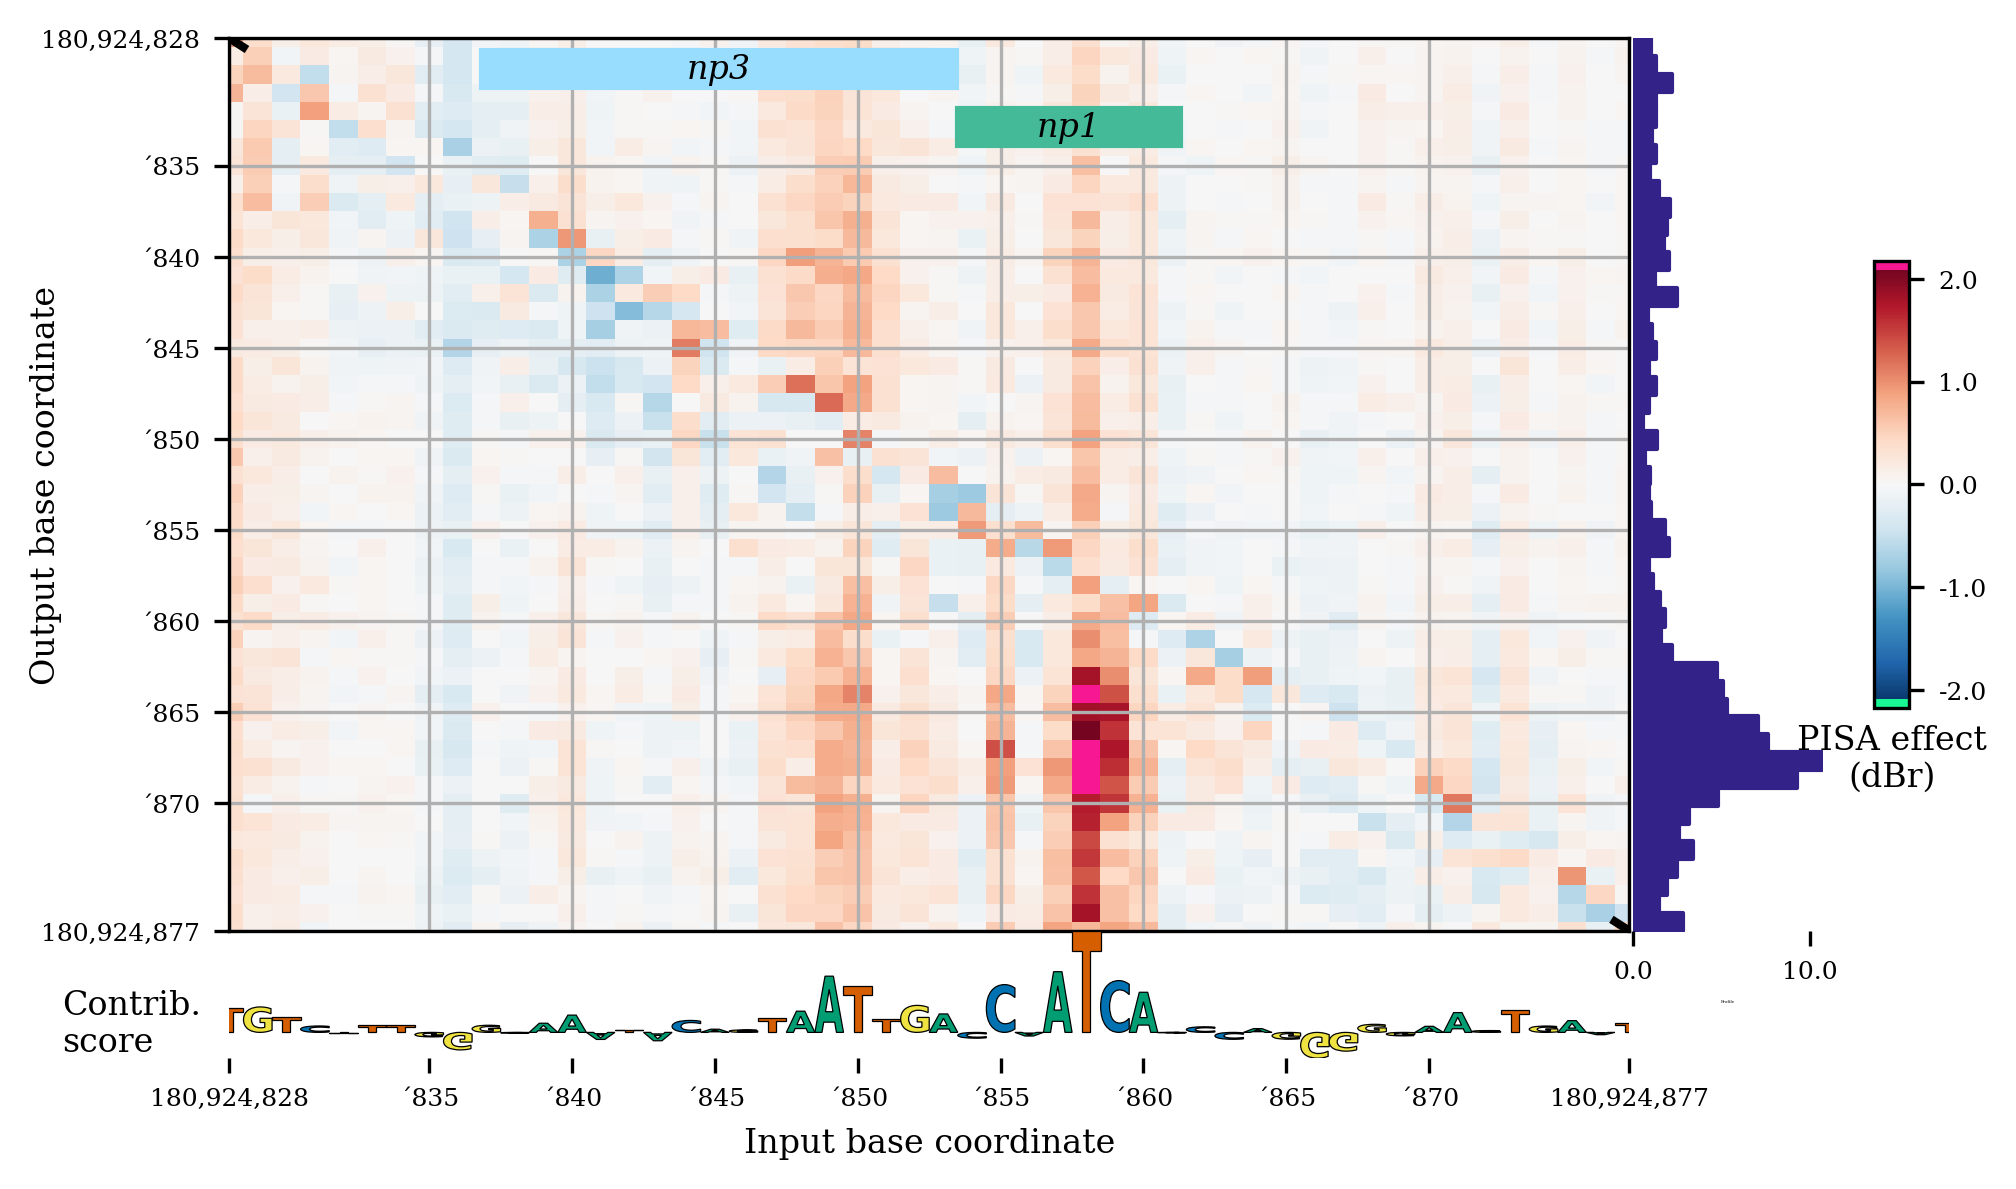

In [20]:
import bpreveal.internal.plotUtils as pu
importlib.reload(pu)
importlib.reload(bprplots)
fig = plt.figure(figsize=(7,4), dpi=300)
#fig.add_axes([0,0,1,1])
pisaSection = {
    "h5-name": WORKING_DIRECTORY + "/shap/pisa_nanog_negative.h5"
}

coordinatesSection = {
    "genome-fasta": GENOME_FASTA,
    "midpoint-offset": 1100,
    "input-slice-width": 50,
    "output-slice-width": 50,
    "genome-window-start": windowStart,
    "genome-window-chrom": windowChrom
}

predictionSection = {
    "bigwig-name": WORKING_DIRECTORY + "/pred/nanog_residual_negative.bw"
}

importanceSection = {
    "bigwig-name": WORKING_DIRECTORY + "/shap/nanog_profile.bw",
    "show-sequence": True
}

annotationSection = {
    "bed-name": WORKING_DIRECTORY + "/scan/nanog_profile.bed"
}

figureSectionPlot = {
    "left": 0.12,
    "bottom": 0.13,
    "width": 0.8,
    "height": 0.85,
    "color-span": 0.5
}

plotConfig = {
    "pisa": pisaSection,
    "coordinates": coordinatesSection,
    "importance": importanceSection,
    "predictions": predictionSection,
    "annotations": annotationSection,
    "figure": figureSectionPlot,
    "miniature": False
}


bprplots.plotPisa(plotConfig, fig);

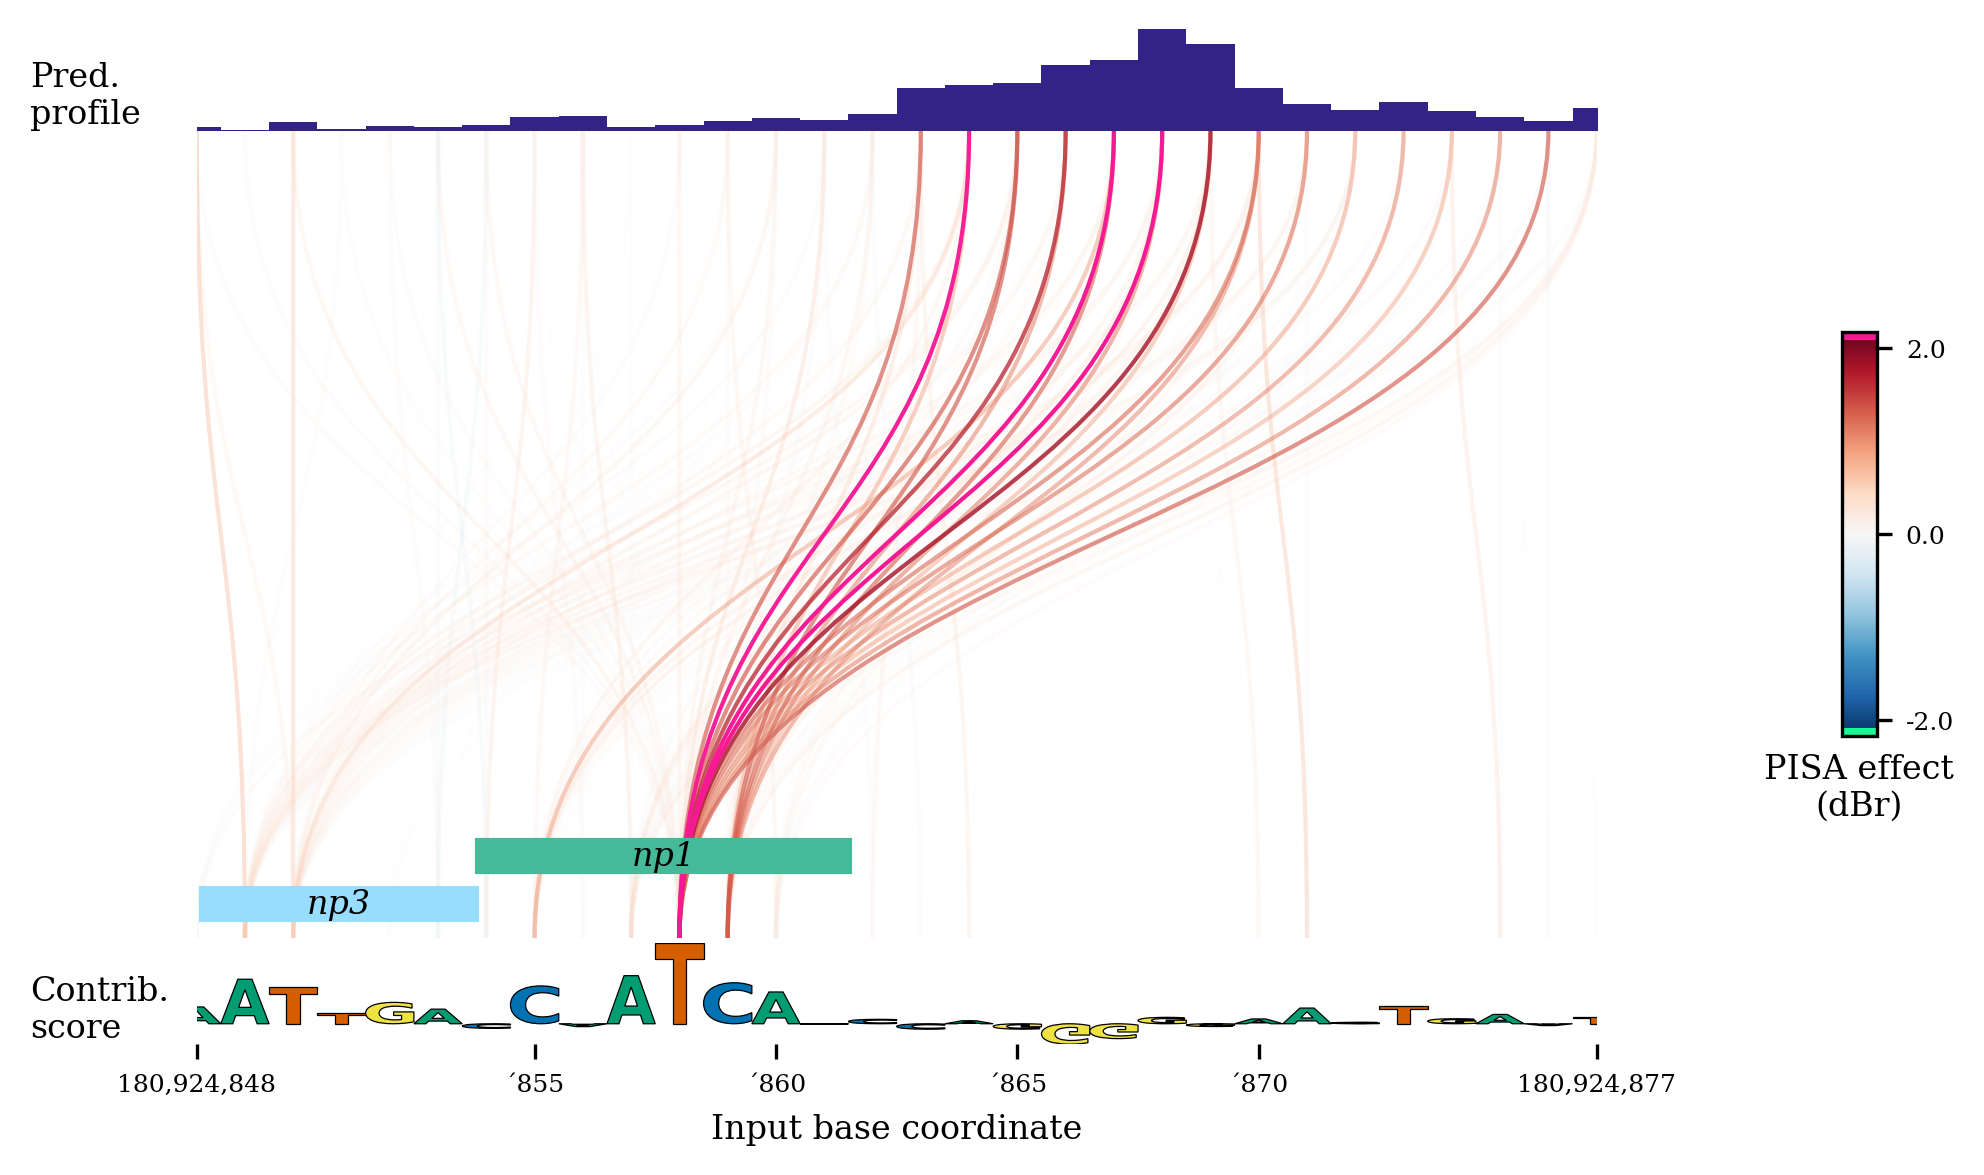

In [21]:
import bpreveal.internal.plotUtils as pu
importlib.reload(pu)
importlib.reload(bprplots)
fig = plt.figure(figsize=(7,4), dpi=300)
#fig.add_axes([0,0,1,1])
pisaSection = {
    "h5-name": WORKING_DIRECTORY + "/shap/pisa_nanog_negative.h5"
}

coordinatesSection = {
    "genome-fasta": GENOME_FASTA,
    "midpoint-offset": 1110,
    "input-slice-width": 30,
    "output-slice-width": 50,
    "genome-window-start": windowStart,
    "genome-window-chrom": windowChrom
}

predictionSection = {
    "bigwig-name": WORKING_DIRECTORY + "/pred/nanog_residual_negative.bw"
}

importanceSection = {
    "bigwig-name": WORKING_DIRECTORY + "/shap/nanog_profile.bw",
    "show-sequence": True
}

annotationSection = {
    "bed-name": WORKING_DIRECTORY + "/scan/nanog_profile.bed"
}

figureSectionPlot = {
    "left": 0.12,
    "bottom": 0.13,
    "width": 0.8,
    "height": 0.85,
    "color-span": 0.5,
    "annotation-height": 0.2
}

graphConfig = {
    "pisa": pisaSection,
    "coordinates": coordinatesSection,
    "importance": importanceSection,
    "predictions": predictionSection,
    "annotations": annotationSection,
    "figure": figureSectionPlot,
    "min-value": 0.1
}


r = bprplots.plotPisaGraph(graphConfig, fig);
#r["axes"]["predictions"].set_xticks(r["axes"]["importance"].get_xticks())
#r["axes"]["predictions"].set_xticklabels(r["axes"]["importance"].get_xticklabels())